In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
import requests
from BinanceCollector import BinanceCollector
from TradeBook import TradeBook
import warnings
import pandas_ta as ta
import talib
warnings.filterwarnings("ignore")

c:\Users\deves\AppData\Local\Programs\Python\Python37\lib\site-packages\requests\__init__.py:114: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning,


In [2]:
_from = "2022-01-01"
_to = "2022-12-29"
_interval = "15m"
_symbol = "UNIUSDT"

In [9]:
collector = BinanceCollector(_symbol,_from,_to,_interval)
collector.start_collect()
collector.df.columns = ["Open Time","Open","High","Low","Close","Volume","Close Time",
             "Quote asset volumne","Total Trades","Buyer Base Volume",
             "Taker buy quote asset volume","Ignore"]
data = collector.df

In [10]:
data.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote asset volumne,Total Trades,Buyer Base Volume,Taker buy quote asset volume,Ignore
0,1.640996e+12,17.10,17.12,17.03,17.04,24345.57,1.640997e+12,415849.9904,805.0,11863.14,202703.1137,0.0
1,1.640997e+12,17.04,17.22,17.02,17.18,23246.50,1.640998e+12,397991.6415,1087.0,14562.99,249507.2653,0.0
2,1.640998e+12,17.17,17.24,17.15,17.21,20828.25,1.640999e+12,358136.6699,980.0,7785.41,133929.2104,0.0
3,1.640999e+12,17.20,17.31,17.12,17.31,22238.01,1.641000e+12,382702.2645,1130.0,16597.30,285771.2866,0.0
4,1.641000e+12,17.29,17.37,17.28,17.33,18773.92,1.641001e+12,325334.2542,1184.0,11077.62,192029.0644,0.0


In [11]:
data["Open Time"] = pd.to_datetime(data["Open Time"],unit="ms")
data["Close Time"] = pd.to_datetime(data["Close Time"],unit="ms")
# Calculate the RSI
data["RSI"] = talib.RSI(data["Close"], timeperiod=14)

# Calculate MA
# data["SMA_50"] = data["Close"].rolling(window=20).mean()
# data["SMA_200"] = data["Close"].rolling(window=50).mean()
data["SMA_50"] = data["Close"].ewm(span=20,adjust=False).mean()
data["SMA_200"] = data["Close"].ewm(span=50,adjust=False).mean()
# data["SMA_50"] = ta.ema(data["Close"],timeperiod=20)
# data["SMA_200"] = ta.ema(data["Close"],timeperiod=50)

data= data[ data["SMA_200"].notna() ]

# Calculate the MACD
data["MACD"], data["MACD_Signal"], data["MACD_Hist"] = talib.MACD(data["Close"], fastperiod=12, slowperiod=26, signalperiod=9)

data = data.reset_index()

In [12]:
# Initialize the signals
data["Signal_RSI"] = np.where(data["RSI"] < 30, 1, 0)
# data["Signal_RSI"] = np.where((data["RSI"] > 70) | (data["RSI"] < 30), 1, 0)
data["Signal_MA"] = np.where((data["SMA_50"] > data["SMA_200"]) & (data["SMA_50"].shift(1) <= data["SMA_200"].shift(1)), 1, 0)
data["Signal_MACD"] = np.where( (data["MACD"] > data["MACD_Signal"]) & (data["MACD"].shift(1) <= data["MACD_Signal"] ) & ( data["MACD_Signal"] < -0.4 ),1,0 )

# Shift the signals one day forward
data["Signal_RSI"] = data["Signal_RSI"].shift(1)
data["Signal_MA"] = data["Signal_MA"].shift(1)
data["Signal_MACD"] = data["Signal_MACD"].shift(1)

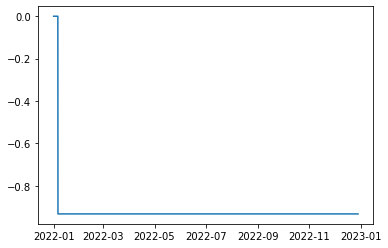

In [13]:
# Calculate the returns
data["Return"] = (data["Close"] - data["Open"])*100/data["Open"]

# Calculate the strategy returns
data["Strategy Return"] = data["Signal_MACD"] * data["Return"]

# Calculate the cumulative returns
data["Cumulative Return"] = data["Strategy Return"].cumsum()

# Plot the returns
# data[["Cumulative Return"]].plot(figsize=(10, 5),)
plt.plot(data["Open Time"],data["Cumulative Return"])

In [15]:
trades = 0
returns = 0
wins = 0
losses = 0
neutral = 0
last_trade = 0
book = TradeBook(_symbol,_from+"_"+_to,_interval,custom_fields=["SMA_20","SMA_50"])
for index in np.where( (data["Signal_MA"] == 1) )[0]:
    if index < last_trade:
        continue
    target = 5/100
    sl = 2/100
    target_price = data["Open"][index] * (1+target)
    sl_price = data["Open"][index] * (1-sl)
    cur = index+1
    settled = False
    while cur < index+96 and cur < len(data):
        if data["High"][cur] >= target_price:
            settled = True
            returns += target*100
            wins += 1
            book.add_entry([str(data["Open Time"][index]),str(data["Open"][index]),
                        str(data["Close"][cur]),str(data["Close Time"][cur]),
                        str( target*100  ), str(data["SMA_50"][index]), str(data["SMA_200"][index]) ])
            break
        elif data["Low"][cur] <= sl_price:
            settled = True
            returns -= sl*100
            losses += 1
            book.add_entry([str(data["Open Time"][index]),str(data["Open"][index]),
                        str(data["Close"][cur]),str(data["Close Time"][cur]),
                        str( -sl*100 ) , str(data["SMA_50"][index]), str(data["SMA_200"][index])])
            break
        cur += 1
    if not settled:
        if cur == len(data):
            cur -= 1
        returns += (data["Close"][cur] - data["Open"][index])*100/data["Open"][index] 
        neutral += 1
        book.add_entry([str(data["Open Time"][index]),str(data["Open"][index]),
                        str(data["Close"][cur]),str(data["Close Time"][cur]),
                        str( (data["Close"][cur] - data["Open"][index])*100/data["Open"][index]  ),
                        str(data["SMA_50"][index]), str(data["SMA_200"][index]) ])
    last_trade = cur

        
print(f"Returns: {returns}")

Returns: 28.64440543140202
